In [1]:
!pip install photutils

Defaulting to user installation because normal site-packages is not writeable


In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 13

c:\program files\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from astropy.visualization import ZScaleInterval

def my_python_ds9(data):
    norm = ZScaleInterval()
    vmin, vmax = norm.get_limits(data)
    plt.imshow(data, vmin=vmin, vmax=vmax, interpolation='none', origin='lower')
    plt.colorbar()

Filename: 20221105/TRES2B_10s_bin4_V0124.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (1024, 1024)   float32   


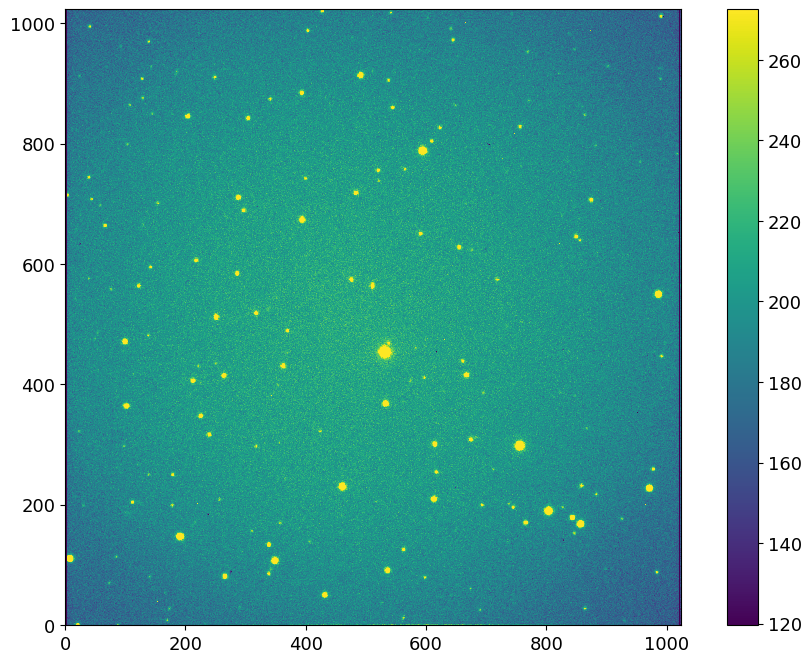

In [3]:
TRES2B_show = fits.open('20221105/TRES2B_10s_bin4_V0124.fits')
TRES2B_show.info()
my_python_ds9(TRES2B_show[0].data)

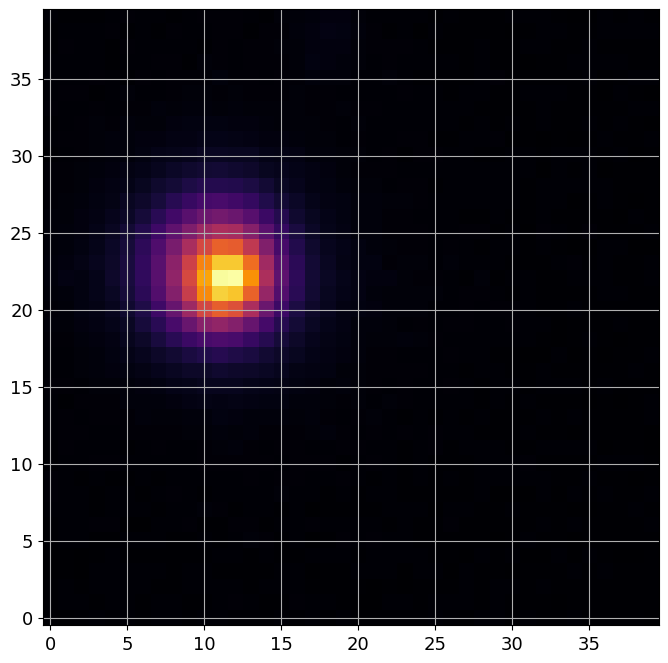

In [4]:
plt.imshow(np.power(TRES2B_show[0].data[430:470, 520:560], 0.5), cmap='inferno', origin='lower')
plt.grid('off')

In [14]:
brightness = []
for filename in ["20221105/TRES2B_10s_bin4_V0{0:03}.fits".format(i) for i in range(1,125)]:
    TRES2B = fits.open(filename)
    mean, median, std = sigma_clipped_stats(TRES2B[0].data, sigma=3.0)
    sigma_detection = 300.0
    daofind = DAOStarFinder(fwhm= 5, threshold=sigma_detection*std)    
    sources = daofind(TRES2B[0].data - median)
    positions = [(x,y) for x,y in zip(sources['xcentroid'], sources['ycentroid'])]   
    apertures = CircularAperture(positions, r=3.)
    #annulus_aperture = CircularAnnulus(positions, r_in=7, r_out=14)
    phot_table = aperture_photometry(TRES2B[0].data, apertures)
    phot_table.sort('aperture_sum', reverse = True)
    aperture_sum_sort = phot_table['aperture_sum']
    brightness.append(aperture_sum_sort[0]/aperture_sum_sort[1])

In [18]:
brightness = []
for filename in ["20221105/TRES2B_10s_bin4_V0{0:03}.fits".format(i) for i in range(1,125)]:
    TRES2B = fits.open(filename)
    mean, median, std = sigma_clipped_stats(TRES2B[0].data, sigma=3.0)
    sigma_detection = 100.0
    daofind = DAOStarFinder(fwhm= 5, threshold=sigma_detection*std)    
    sources = daofind(TRES2B[0].data - median)
    positions = [(x,y) for x,y in zip(sources['xcentroid'], sources['ycentroid'])]   
    apertures = CircularAperture(positions, r=10.)
    annulus_aperture = CircularAnnulus(positions, r_in=18, r_out=28)
    phot_table = aperture_photometry(TRES2B[0].data, apertures)
    back_table = aperture_photometry(TRES2B[0].data, annulus_aperture)
    phot_table['aperture_diff'] = phot_table['aperture_sum'] - back_table['aperture_sum']*100/460
    phot_table.sort('aperture_diff', reverse = True)
    aperture_diff_sort = phot_table['aperture_diff']
    brightness.append(aperture_diff_sort[0]/(aperture_diff_sort[1]+aperture_diff_sort[2]))

In [36]:
from statistics import stdev

# Find the standard deviation of the numbers
std_dev = stdev(brightness[55:])

# Print the standard deviation
print(std_dev)

0.004745170235178595


In [27]:
0.0023059629538175292/std_dev**2

77.3744356190132

In [29]:
0.0027840965970260052/std_dev**2

93.41776395283252

In [19]:
turn_point_best = 0
residual_sum_best = 9999
for turn_point in range(10,123):
    x_test = np.array([i for i in range(1,turn_point)]).reshape(-1, 1)
    model = LinearRegression().fit(x_test,brightness[:turn_point-1])
    prediction = model.predict(x_test)
    residual_sum = sum((brightness[:turn_point-1] - prediction)**2)
    for i in range(turn_point,124):
        residual_sum += (brightness[i] - prediction[-1])**2
    print(turn_point, residual_sum)
    if residual_sum<residual_sum_best:
        turn_point_best = turn_point
        residual_sum_best = residual_sum
print(turn_point_best)

10 0.005254332642547243
11 0.004165229874723204
12 0.0056530504779368
13 0.006190841093514212
14 0.005641203105831767
15 0.00589653298782477
16 0.007278528555709773
17 0.005190940900908148
18 0.004323273287895179
19 0.0034860540078193777
20 0.0030031682526740155
21 0.0031744773269688207
22 0.0033937769567854155
23 0.0032790313049776494
24 0.003235508172022512
25 0.0033503029404285613
26 0.0030303112422951466
27 0.0032057673875702845
28 0.0034226505381130556
29 0.003450609699970453
30 0.003353440977192548
31 0.0033988623307273417
32 0.0034796369039868397
33 0.0036680036390144954
34 0.003602242979509224
35 0.0037453303296188186
36 0.003997677149911567
37 0.0036179972019901824
38 0.003941669732772771
39 0.0036416985637001947
40 0.0033124729735309116
41 0.0034896182879838545
42 0.0037334522138443692
43 0.00408769132894438
44 0.004117941232927963
45 0.003959480782541265
46 0.0038379765598638062
47 0.0034932328992304923
48 0.003245541188104471
49 0.0032909050304113278
50 0.003082274770602729

In [48]:
import numpy as np
from sklearn.linear_model import LinearRegression
turn_point = 64
x_test = np.array([i for i in range(1,turn_point)]).reshape(-1, 1)
model = LinearRegression().fit(x_test,brightness[:turn_point-1])
prediction = model.predict(x_test)
residual_sum = sum((brightness[:turn_point-1] - prediction)**2)
for i in range(turn_point,124):
    residual_sum += (brightness[i] - np.mean(brightness[turn_point:]))**2
print(residual_sum)
if residual_sum<residual_sum_best:
    turn_point_best = turn_point
    residual_sum_best = residual_sum

0.0023050630434914366


In [49]:
best_mcmc = np.array([1.63116853e-04, 6.20118136e+01, 1.37238328e+00])
def mcmc(x):
    slope, turn_point, flat = best_mcmc
    output = np.zeros(x)
    for i in range(x):
        if i >= turn_point:
            output[i] = flat
        else:
            output[i] = flat-slope*(turn_point-i)
    return(output)

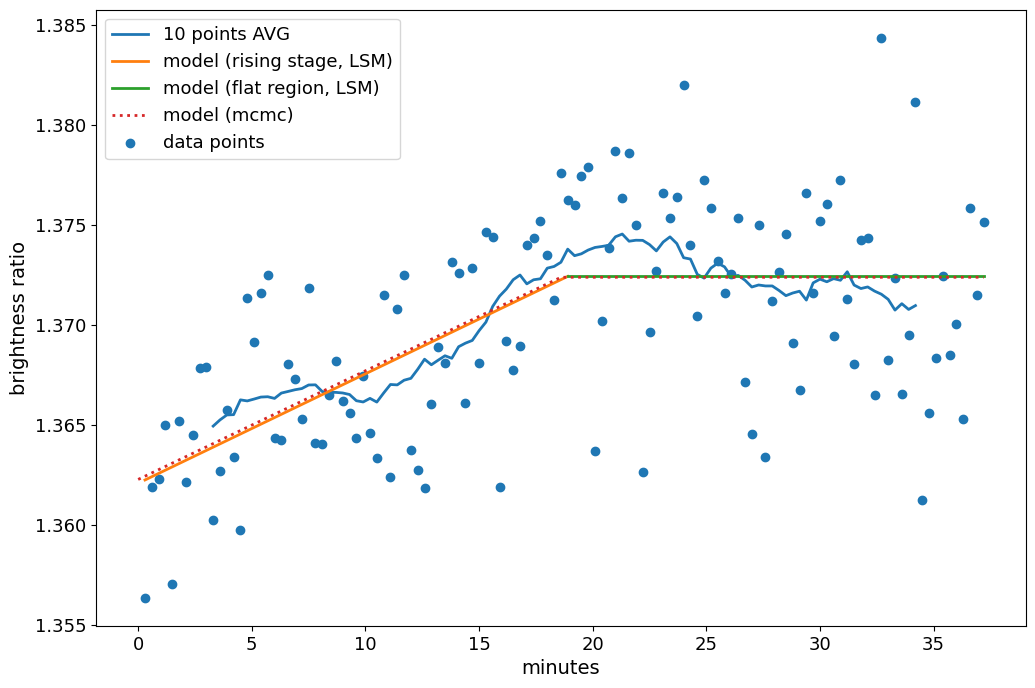

In [58]:
import matplotlib.pyplot as plt
brightness_av20 = []
for i in range(1,105):
    brightness_av20.append(sum(brightness[i:i+20])/20)
plt.plot([0.3*i for i in range(11,115)],brightness_av20, label="10 points AVG")
plt.plot([0.3*i for i in x_test], prediction, label="model (rising stage, LSM)")
plt.plot([0.3*i for i in range(turn_point-1,125)], [prediction[-1] for i in range (turn_point-1,125)], label="model (flat region, LSM)")
plt.plot([0.3*i for i in range(125)], mcmc(125), label="model (mcmc)", linestyle=':')
plt.scatter([0.3*i for i in range(1,125)],brightness, label="data points")
plt.xlabel("minutes")
plt.ylabel("brightness ratio")
plt.legend()
plt.savefig("models.png")